In [1]:
import pandas as pd
# from re import sub
from regex import sub, match, findall


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_excel('/content/drive/MyDrive/ITMO/MLSys/telegram_posts.xlsx')
# df.dropna(inplace=True)
df.head()

Scraping ID             Group      Author ID  \
0    #ID00001  @rybolos_channel -1001568817860   
1    #ID00002  @rybolos_channel -1001568817860   
2    #ID00003  @rybolos_channel -1001568817860   
3    #ID00004  @rybolos_channel -1001568817860   
4    #ID00005  @rybolos_channel -1001568817860   

                                             Content                 Date  \
0  Не хочу особо вам писать про 2023, очень много...  2022-12-31 14:24:35   
1  #шитпост \nStrong Свиборг vibes\nhttps://youtu...  2022-12-30 10:38:30   
2                       Чёт хочется шитпостить уже 🎄  2022-12-30 10:35:48   
3  #nlp #про_nlp \n**Итоги года в Natural Languag...  2022-12-29 13:57:58   
4            #шитпост \nhttps://youtu.be/4HvsLXjgaUI  2022-12-27 16:18:06   

   Message ID            Author   Views                 Reactions  Shares  \
0         441  Tatiana Shavrina  2348.0         ❤ 27 👍 3 🤡 1 🆒 1      8.0   
1         440  Tatiana Shavrina  2182.0          🔥 8 👍 4 ❤ 2 💩 1      3.0   
2         439  Tatiana Shavrina  2064.0             ❤ 25 🔥 4 ⚡ 1      0.0   
3         438  Tatiana Shavrina  3418.0  ❤‍🔥 32 👍 20 🔥 5 ❤ 2 🤮 1    101.0   
4         437  Tatiana Shavrina  2368.0      ❤ 9 😁 4 👍 3 🤮 3 🔥 2     23.0   

                              Media  \
0  https://t.me/rybolos_channel/441   
1  https://t.me/rybolos_channel/440   
2                          no media   
3  https://t.me/rybolos_channel/438   
4  https://t.me/rybolos_channel/437   

                                            Comments  
0  2023 год Метахимии?!\n\nУ жизни два стимула дл...  
1  https://youtu.be/VT6exin7G9s;\nhttps://youtu.b...  
2                         ;\n;\n;\nвамос шитпост!;\n  
3                                                NaN  
4                                                NaN

In [9]:
df = df.fillna('')

<Axes: >

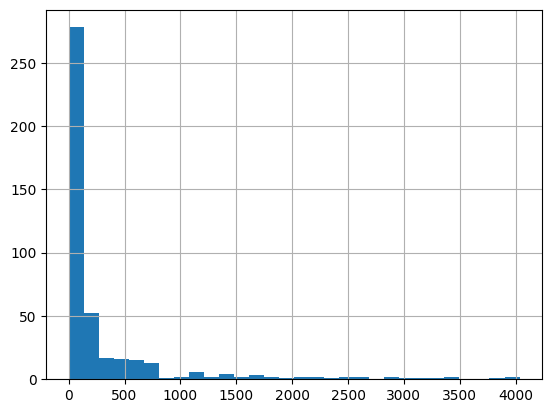

In [10]:
df['len_text'] = df['Content'].apply(len)
df.len_text.hist(bins=30)

In [11]:
df.len_text.value_counts().head(10)

0      100
38       6
15       6
49       5
166      4
82       4
158      4
86       4
106      4
19       4
Name: len_text, dtype: int64

In [13]:
from urllib.parse import urlparse

def redactor(text):
    text = str(text).lower()
    text = sub('[7-8]{1}[0-9]{8,10}', ' номер телефона ', text)
    text = sub('([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+',
                  ' адрес электронной почты ', text)

    for site in set(findall("(?P<url>https?://[^\s]+)", text)):
        try:
            new_site = urlparse(site).netloc
        except:
            continue
            # print(text, '\n', site)
        text = text.replace(site, new_site)

    if len(text) > 50:
        for word in text.split():
            if len(word) > 50:
                text = text.replace(word, '')
    return text

print(
    redactor(
        'Привет всем, можете написать мне в личку 79232552701 или на почту hren@mail.ru'
        )
    )

привет всем, можете написать мне в личку  номер телефона  или на почту  адрес электронной почты 


In [ ]:
pip install pandas jupyter pandarallel requests tqdm


In [15]:
import pandas as pd
import requests

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=100)

INFO: Pandarallel will run on 100 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
valid_signs = set('•@:#$%^&*()~qwertyuiop[]asdfghjkl;zxcvbnm,./1234567890-=_—+йцукенгшщзхъфывапролджёэячсмитьбю!^?… \\ \n \r \t >< \xa0 ← → |{}"–©№»« \u200b ∙ ’“”'+"'")
empty_set = set([])

df['valid_lang'] = df['Content'].parallel_apply(lambda text: set(text.lower()) - valid_signs == empty_set)

In [18]:
df.valid_lang.value_counts()

True     337
False     96
Name: valid_lang, dtype: int64

In [ ]:
df = df.loc[df.valid_lang == True]
df

In [19]:
df['typ'] = df['Content'].parallel_apply(type)

In [20]:
df.typ.value_counts()

<class 'str'>    433
Name: typ, dtype: int64

In [22]:
df["pre_desc"] = df['Content'].parallel_apply(redactor)


<Axes: >

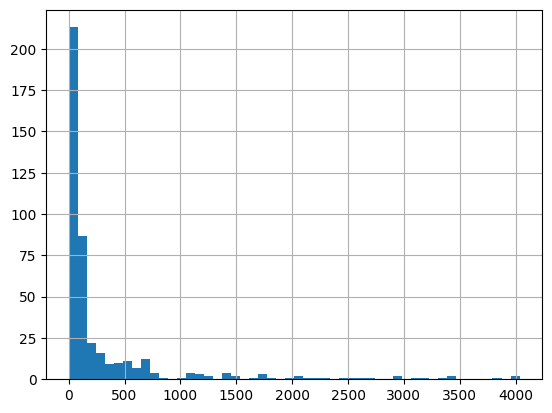

In [23]:
df['len_pre_text'] = df['Content'].apply(len)
# df = df.loc[df.len_pre_text < df.len_pre_text.quantile(0.95)]
df['len_pre_text'].hist(bins=50)

<Axes: >

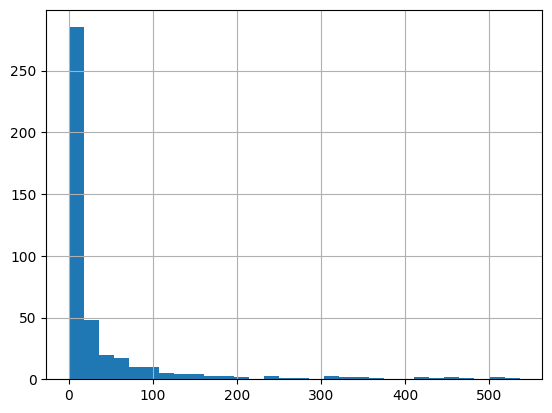

In [25]:
df['word_count'] = df['Content'].apply(lambda text: len(text.split()))
df['word_count'].hist(bins=30)


<Axes: >

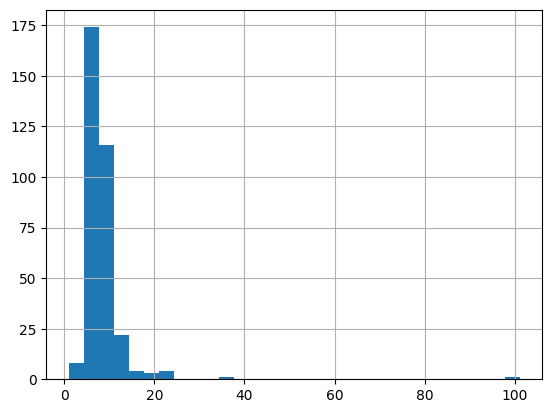

In [26]:
df['mean_len_word'] = df['len_pre_text'] / df['word_count']
df['mean_len_word'].hist(bins=30)

In [30]:
df['max_len_word'] = df['Content'].apply(lambda text: max(0, map(len, text.split())))
df.max_len_word.hist(bins=40)

TypeError: ignored

In [ ]:
# from pandas.core.array_algos import quantile
# df.loc[df.max_len_word > df.max_len_word.quantile(0.999)]

In [ ]:
for target in target_cols:
    df[target] = 0
    df.loc[df.group == target, target] = 1
df

# Обученние

In [31]:
target = 'label'
text_col = 'pre_desc'

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = pd.DataFrame([]), pd.DataFrame([])
df_train[text_col], df_val[text_col], df_train[target], df_val[target] = train_test_split(df['text'], df['group'], test_size=0.1, random_state=42)


In [ ]:
df_train.to_csv('/content/drive/MyDrive/ITMO/MLSys/df_train.csv', sep=';', index=False)

In [ ]:
df_val.to_csv('/content/drive/MyDrive/ITMO/MLSys/df_val.csv', sep=';', index=False)

In [ ]:
df_train[target].value_counts()

In [ ]:
df_val[target].value_counts()

# Подготовка модели

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoConfig, BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os
from torch.nn import Softmax
import pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/ITMO/MLSys/df_train.csv', sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/ITMO/MLSys/df_val.csv', sep=';')

In [ ]:
with open('/content/drive/MyDrive/ITMO/MLSys/targets.txt', 'r') as file:
    target_cols = file.read().split('\n')
target_cols

In [ ]:
for target_col in target_cols:
    df_val[target_col.strip()] = 0
    df_val.loc[df_val[target] == target_col, target_col.strip()] = 1

    df_train[target.strip()] = 0
    df_train.loc[df_train[target] == target_col, target_col.strip()] = 1

In [ ]:
df_val.columns

In [ ]:
df_val.drop([target, 'Unnamed: 0'], axis=1, inplace=True)
df_train.drop([target, 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [ ]:

#MAX_LEN = 230
MAX_LEN = 220
TRAIN_BATCH_SIZE = 48
VALID_BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational')


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        # print(*inputs, end='\n'+'_____'*50+'\n')


        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_val, tokenizer, MAX_LEN)


In [ ]:
# changed num_workers in train from 4 to 2 - doesnt work
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=1, shuffle=False, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch.nn as nn

In [ ]:
assert len(df_val.columns) == len(df_train.columns), "Разное кол-во столбцов"

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
targets_len = len(target_cols)

class BERTClass(torch.nn.Module):
    def __init__(self, freeze_bert=False):
        super(BERTClass, self).__init__()
        #self.roberta = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

        self.bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-conversational')

        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        # D_in, H = 768, 50

        # # Instantiate an one-layer feed-forward classifier
        # self.classifier = nn.Sequential(
        #     nn.Linear(D_in, H),
        #     nn.ReLU(),
        #     #nn.Dropout(0.5),
        #     nn.Linear(H, targets_len)
        # )

#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, targets_len)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False


    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass(freeze_bert=False)
model.to(device);

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(8,8),
                          # ratio = True,
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    cm = confusion_matrix(y_true, y_pred).T

    # if ratio:
    #   for column in range(len(cm[0])):
    #     for step in range(len(cm)):
    #       cm[step, column]

    if normalize:
        print(cm)
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]


    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.grid()
    plt.show()
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')



# Цикл обучения

In [ ]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():

      for _, data in tqdm(enumerate(valid_loader, 0)):

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
!pip install pretty-confusion-matrix

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data, pp_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
# !pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
MODELS_PATH_DIR = ''
max_f1_score_micro = -1

for epoch in range(EPOCHS):
    train(epoch)

    outputs_raw, targets = validation()

    outputs_prep = np.argmax(outputs_raw, axis=1)
    targets_prep = np.argmax(targets, axis=1)

    cfm = confusion_matrix(targets_prep, outputs_prep)
    # print(cfm)
    df_cm = pd.DataFrame(cfm, index=target_cols,
                        columns=target_cols
                         )

    # colormap: see this and choose your more dear
    cmap = 'PuRd'
    pp_matrix(df_cm, cmap=cmap, figsize=[30, 30])

    plot_confusion_matrix(targets_prep, outputs_prep, target_cols, figsize=(30,30), normalize=True)
    plot_confusion_matrix(targets_prep, outputs_prep, target_cols, figsize=(30,30), normalize=False)

    accuracy = metrics.accuracy_score(targets_prep, outputs_prep)
    f1_score_micro = metrics.f1_score(targets_prep, outputs_prep, average='micro')
    f1_score_macro = metrics.f1_score(targets_prep, outputs_prep, average='macro')

    if f1_score_micro > max_f1_score_micro:

      print("Score improved {0} -----> {1} . Model saved as model_{1}.bin. ".format(max_f1_score_micro, f1_score_micro))

      max_f1_score_micro = f1_score_micro

      torch.save(model.state_dict(), os.path.join(MODELS_PATH_DIR, 'model_{}.bin'.format(f1_score_micro)))




    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")